# PolEval task1

## Wczytanie potrzebnych bibliotek i funkcja plot_graphs

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Edycja danych wejściowych


Zmieniam pliki na datasety, które mają w sobie pary tensorów, jeden typu string drugi typu int

In [ ]:
tags = open("/content/training_set_clean_only_tags.txt", encoding='utf8')
texts = open("/content/training_set_clean_only_text.txt", encoding='utf8')


dataset1 = tf.data.Dataset.from_tensor_slices(texts.readlines())
dataset2 = tf.data.Dataset.from_tensor_slices([ int(x) for x in tags.readlines()])

texts.close()
tags.close()

dataset = tf.data.Dataset.zip((dataset1, dataset2))
dataset


tags = open("/content/test_set_clean_only_tags.txt", encoding='utf8')
texts = open("/content/test_set_clean_only_text.txt", encoding='utf8')


dataset1_test = tf.data.Dataset.from_tensor_slices(texts.readlines())
dataset2_test = tf.data.Dataset.from_tensor_slices([ int(x) for x in tags.readlines()])

texts.close()
tags.close()

dataset_test = tf.data.Dataset.zip((dataset1_test, dataset2_test))


In [ ]:
for example, label in dataset.take(3):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'Dla mnie faworytem do tytu\xc5\x82u b\xc4\x99dzie Cracovia. Zobaczymy, czy typ si\xc4\x99 sprawdzi.\n'
label:  0
text:  b'@anonymized_account @anonymized_account Brawo ty Daria kibic ma by\xc4\x87 na dobre i z\xc5\x82e\n'
label:  0
text:  b'@anonymized_account @anonymized_account Super, polski premier sk\xc5\x82ada kwiaty na grobach kolaborant\xc3\xb3w. Ale doczekali\xc5\x9bmy czas\xc3\xb3w.\n'
label:  0


Zmiana nazwy datasetu:

In [ ]:
train_dataset = dataset
test_dataset = dataset_test

Tworzenie batchów i shuffle:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'@anonymized_account Spokojnie w wielu klubach zatrudnia sie zawodnikow na podstawie opinii.A Ondrasek ma opinie solidnego napastnika \xf0\x9f\x98\x82\n'
 b'@anonymized_account ej, dobra, we\xc5\xbamie ten chrzest czy nie? xd\n'
 b'@anonymized_account W\xc5\x82a\xc5\x9bnie, trzeba Ipl\xc4\x99 wy\xc5\x82aczy\xc4\x87 \xf0\x9f\x98\x85\n']

labels:  [0 0 0]


## Encoder

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'anonymizedaccount', 'nie', 'to', 'w', 'na', 'i',
       'się', 'z', 'a', 'że', 'jak', 'jest', 'do', 'ale', 'co', 'o',
       'tak', 'rt'], dtype='<U17')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2, 405,   5,   1,   1,   1,  97,   1,   6, 884,   1,   1,  23,
          1,   1,   1,  44,   0,   0,   0,   0,   0,   0],
       [  2, 257, 184,   1,  42,   1,  25,   3,  64,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2, 138,  79,   1,   1,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'@anonymized_account Spokojnie w wielu klubach zatrudnia sie zawodnikow na podstawie opinii.A Ondrasek ma opinie solidnego napastnika \xf0\x9f\x98\x82\n'
Round-trip:  anonymizedaccount spokojnie w [UNK] [UNK] [UNK] sie [UNK] na podstawie [UNK] [UNK] ma [UNK] [UNK] [UNK] 😂      

Original:  b'@anonymized_account ej, dobra, we\xc5\xbamie ten chrzest czy nie? xd\n'
Round-trip:  anonymizedaccount ej dobra [UNK] ten [UNK] czy nie xd              

Original:  b'@anonymized_account W\xc5\x82a\xc5\x9bnie, trzeba Ipl\xc4\x99 wy\xc5\x82aczy\xc4\x87 \xf0\x9f\x98\x85\n'
Round-trip:  anonymizedaccount właśnie trzeba [UNK] [UNK] [UNK]                 



## Model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

## Trenowanie modelu

In [ ]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/20
314/314 [==============================] - 12s 22ms/step - loss: 0.3038 - accuracy: 0.9152 - val_loss: 0.3434 - val_accuracy: 0.8719
Epoch 2/20
314/314 [==============================] - 5s 17ms/step - loss: 0.2305 - accuracy: 0.9173 - val_loss: 0.3658 - val_accuracy: 0.8719
Epoch 3/20
314/314 [==============================] - 6s 18ms/step - loss: 0.1936 - accuracy: 0.9227 - val_loss: 0.3760 - val_accuracy: 0.8771
Epoch 4/20
314/314 [==============================] - 6s 18ms/step - loss: 0.1777 - accuracy: 0.9289 - val_loss: 0.3772 - val_accuracy: 0.8792
Epoch 5/20
314/314 [==============================] - 6s 18ms/step - loss: 0.1557 - accuracy: 0.9364 - val_loss: 0.4341 - val_accuracy: 0.8677
Epoch 6/20
314/314 [==============================] - 6s 18ms/step - loss: 0.1427 - accuracy: 0.9431 - val_loss: 0.4472 - val_accuracy: 0.8719
Epoch 7/20
314/314 [==============================] - 6s 18ms/step - loss: 0.1248 - accuracy: 0.9504 - val_loss: 0.5214 - val_accuracy: 0.868

(0.0, 1.2734082583338022)

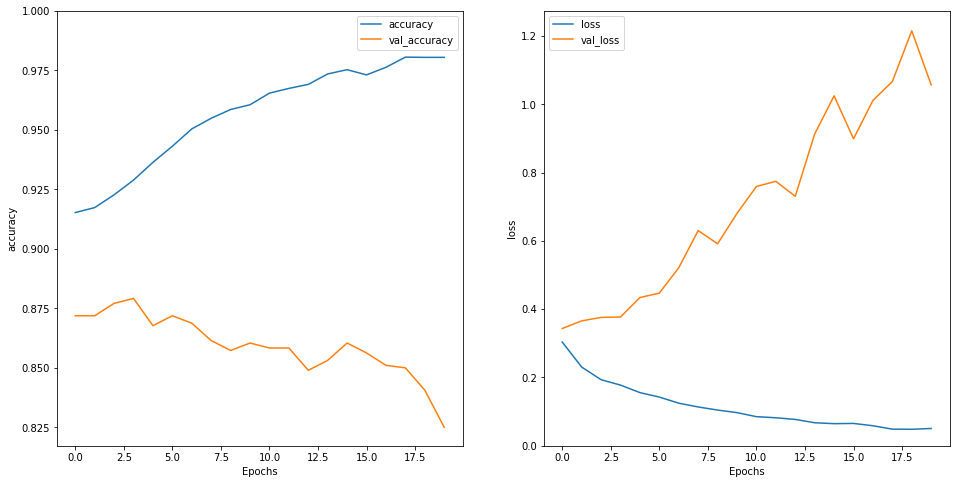

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plot_graphs
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)